# Modeling Climate and Housing Data: Regression
## 90-803 Machine Learning Foundations with Python (Spring 2024)
### Team 17: Yoko, Tessa, Hannah

We are attempting to predict home values (or purchase prices) based on climate indicators, so in this file we are exploring the following:
* Linear Regression
* Polynomial Regressions
* Feature selection

This file should answer the following question:
Can we predict real estate purchase price based on climate indicators?

In [71]:
# importing relevant libraries
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import geopandas as gpd
%matplotlib inline

# Importing metrics for model evaluation
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV 
from sklearn.feature_selection import SequentialFeatureSelector

# Importing class balance tools for handling imbalanced datasets
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from yellowbrick.target import ClassBalance

# Importing classifier models
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

# Import plotyly
import plotly.express as px

# Import state abbreviations and FIPS
from state_names import state_abbreviations, state_to_fips

## Read the data and look at it

In [72]:
data = pd.read_csv("all_data.csv", index_col=0)
data.head()

,Date,Year,Month,RegionName,State,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Value,Anomaly (1901-2000 base period),1901-2000 Mean,StateAbbrv,Initial Fees and Charges (%),Effective Rate (%),Term to Maturity,Loan Amount ($thou),Purchase Price ($thou),Loan-to-Price Ratio (%),Share of Total Market (%)
0,2000-01-31,2000,1,Los Angeles County,CA,"122,826.5452","400,192.7389",52.3000,4.5000,47.8000,CA,0.9300,8.0100,15,103.0000,173.6000,64.7000,7.0000
1,2000-01-31,2000,1,Los Angeles County,CA,"122,826.5452","400,192.7389",52.3000,4.5000,47.8000,CA,0.8100,8.2000,30,129.9000,166.8000,81.1000,61.1000
2,2000-01-31,2000,1,Cook County,IL,"71,689.1880","302,264.5451",24.9000,2.4000,22.5000,IL,0.9300,8.0100,15,103.0000,173.6000,64.7000,7.0000
3,2000-01-31,2000,1,Cook County,IL,"71,689.1880","302,264.5451",24.9000,2.4000,22.5000,IL,0.8100,8.2000,30,129.9000,166.8000,81.1000,61.1000
4,2000-01-31,2000,1,Harris County,TX,"61,195.1756","217,850.4629",57.4000,5.6000,51.8000,TX,0.9300,8.0100,15,103.0000,173.6000,64.7000,7.0000


In [73]:
data.drop(columns=['Date'], inplace=True)
data.rename(columns={'Value': 'Average Temperature Value'}, inplace=True)
data['StateFPS'] = data['StateAbbrv'].map(state_to_fips)

## Read in Geo-data
We want to relate this data to where the counties exist in geospatial relation to one another, so we are going to read county longitude and latitude data and merge it.

In [74]:
# Loading the shapefile in order to visualize clean data on the US map
us_counties = gpd.read_file('tl_2022_us_county/tl_2022_us_county.shp')
print(us_counties.columns)
us_counties.head()

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry'],
      dtype='object')


,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477644346,10691216,+41.9158651,-096.7885168,"POLYGON ((-96.55515 41.91587, -96.55515 41.914..."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680980770,61564427,+46.2946377,-123.4244583,"POLYGON ((-123.72755 46.26449, -123.72755 46.2..."
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016818946,29090018,+34.3592729,-104.3686961,"POLYGON ((-104.89337 34.08894, -104.89337 34.0..."
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,None,None,A,2169272978,22847034,+40.7835474,-096.6886584,"POLYGON ((-96.68493 40.52330, -96.69219 40.523..."
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645185,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27370 40.11840, -98.27374 40.122..."


In [75]:
# Merge the geospatial United States map with the data
data = us_counties.merge(data, left_on=['NAMELSAD', 'STATEFP'], right_on=['RegionName', 'StateFPS'])

data.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,1901-2000 Mean,StateAbbrv,Initial Fees and Charges (%),Effective Rate (%),Term to Maturity,Loan Amount ($thou),Purchase Price ($thou),Loan-to-Price Ratio (%),Share of Total Market (%),StateFPS
0,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,22.2000,NE,0.9300,8.0100,15,103.0000,173.6000,64.7000,7.0000,31
1,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,22.2000,NE,0.8100,8.2000,30,129.9000,166.8000,81.1000,61.1000,31
2,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,27.3000,NE,0.9100,8.1800,15,100.5000,172.8000,63.1000,7.2000,31
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,27.3000,NE,0.7800,8.3900,30,127.8000,163.7000,81.2000,58.6000,31
4,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,38.0000,NE,0.8700,8.2400,15,101.2000,176.9000,62.7000,7.2000,31


In [76]:
# data_2000 = data[data['Year'] == 2001]
# fig, ax = plt.subplots(1, 1, figsize=(12, 6))
# ax.set_xlim(-130, -65)
# ax.set_ylim(24, 50)
# ax.set_axis_off()
# us_counties.geometry.boundary.plot(ax=ax, edgecolor='k',linewidth = 0.5)
# data_2000.plot(column='Average Temperature Value', ax=ax, cmap='Blues')

## Look for multicollinearity

We suspect that housing values may simply change over time due to factors not listed in our dataset, which would make the Year (and possibly the Month) column heavily collinear. As we see below, it does have high collinearity with some features. We will proceed, anyway, but we will keep this in mind.

In [77]:
data.drop(columns=['RegionName', 'State', 'StateAbbrv', \
                       'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',\
                       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT','geometry']).corr()

,ALAND,AWATER,INTPTLAT,INTPTLON,Year,Month,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Average Temperature Value,Anomaly (1901-2000 base period),1901-2000 Mean,Initial Fees and Charges (%),Effective Rate (%),Term to Maturity,Loan Amount ($thou),Purchase Price ($thou),Loan-to-Price Ratio (%),Share of Total Market (%),StateFPS
ALAND,1.0000,0.0449,0.0224,-0.4514,0.0128,-0.0008,0.1133,0.0685,-0.0137,0.0339,-0.0204,0.0125,-0.0122,0.0000,0.0085,0.0078,0.0040,0.0003,-0.1019
AWATER,0.0449,1.0000,0.0396,0.0071,-0.0264,0.0001,0.1254,0.1327,-0.0041,0.0239,-0.0089,-0.0239,0.0246,-0.0000,-0.0184,-0.0181,-0.0083,-0.0001,-0.0318
INTPTLAT,0.0224,0.0396,1.0000,-0.1188,0.0098,0.0002,0.1752,0.0909,-0.4300,0.0424,-0.4393,0.0071,-0.0100,0.0000,0.0057,0.0049,0.0038,0.0007,0.2463
INTPTLON,-0.4514,0.0071,-0.1188,1.0000,-0.0696,0.0003,-0.2423,-0.1690,0.0271,0.0020,0.0268,-0.0601,0.0659,-0.0000,-0.0474,-0.0462,-0.0216,-0.0010,0.1194
Year,0.0128,-0.0264,0.0098,-0.0696,1.0000,-0.0462,0.1187,0.0514,-0.0218,0.0800,-0.0377,0.8399,-0.8382,-0.0000,0.7322,0.7623,0.2923,0.0013,0.0332
Month,-0.0008,0.0001,0.0002,0.0003,-0.0462,1.0000,0.0024,0.0026,0.2249,0.0045,0.2245,0.0165,-0.0197,0.0000,0.0088,0.0005,0.0105,0.0018,-0.0001
Bottom-Tier Average Home Value Estimate,0.1133,0.1254,0.1752,-0.2423,0.1187,0.0024,1.0000,0.8038,-0.0660,0.0748,-0.0810,0.0522,-0.0530,0.0000,0.1104,0.1442,0.0223,-0.0025,-0.0216
Top-Tier Average Home Value Estimate,0.0685,0.1327,0.0909,-0.1690,0.0514,0.0026,0.8038,1.0000,-0.0480,0.0518,-0.0584,0.0056,-0.0154,0.0000,0.0545,0.0788,0.0074,-0.0024,-0.0588
Average Temperature Value,-0.0137,-0.0041,-0.4300,0.0271,-0.0218,0.2249,-0.0660,-0.0480,1.0000,0.1094,0.9804,0.0076,0.0075,0.0000,0.0088,0.0081,0.0030,-0.0103,-0.0962
Anomaly (1901-2000 base period),0.0339,0.0239,0.0424,0.0020,0.0800,0.0045,0.0748,0.0518,0.1094,1.0000,-0.0885,0.1050,-0.0678,0.0000,0.0348,0.0362,0.0166,-0.0150,0.0137


<Axes: >

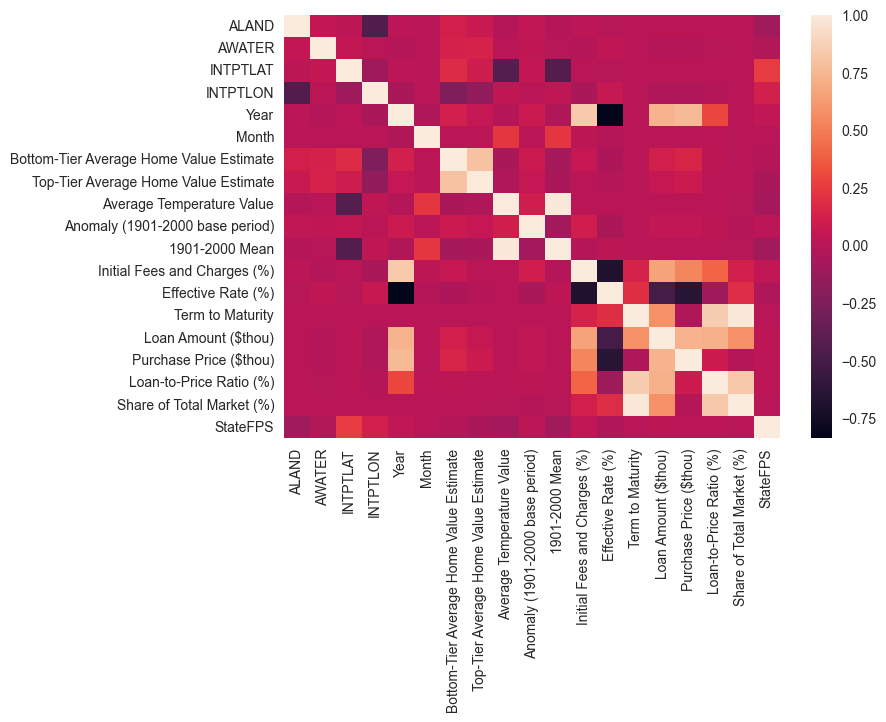

In [78]:
sns.heatmap(data=data.drop(columns=['RegionName', 'State', 'StateAbbrv', \
                       'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',\
                       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT','geometry']).corr())

In [79]:
data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 579894 entries, 0 to 579893
Data columns (total 36 columns):
 #   Column                                   Non-Null Count   Dtype   
---  ------                                   --------------   -----   
 0   STATEFP                                  579894 non-null  object  
 1   COUNTYFP                                 579894 non-null  object  
 2   COUNTYNS                                 579894 non-null  object  
 3   GEOID                                    579894 non-null  object  
 4   NAME                                     579894 non-null  object  
 5   NAMELSAD                                 579894 non-null  object  
 6   LSAD                                     579894 non-null  object  
 7   CLASSFP                                  579894 non-null  object  
 8   MTFCC                                    579894 non-null  object  
 9   CSAFP                                    0 non-null       object  
 10  CBSAFP      

In [80]:
columns_to_scale = data.drop(columns=['Year', 'Month', 'RegionName', 'State', 'StateFPS', 'StateAbbrv', \
                       'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',\
                       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT','geometry']).columns

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the specified columns
scaler.fit(data[columns_to_scale])

# Transform the data using the fitted scaler and convert it back to a DataFrame
scaled_data = scaler.transform(data[columns_to_scale])
scaled_data_df = pd.DataFrame(scaled_data, columns=columns_to_scale, index=data.index)
scaled_data_df['Year'] = data['Year']
scaled_data_df['Month'] = data['Month']
# Display the first few rows of the DataFrame to check the results
scaled_data_df.head()

,ALAND,AWATER,INTPTLAT,INTPTLON,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Average Temperature Value,Anomaly (1901-2000 base period),1901-2000 Mean,Initial Fees and Charges (%),Effective Rate (%),Term to Maturity,Loan Amount ($thou),Purchase Price ($thou),Loan-to-Price Ratio (%),Share of Total Market (%),Year,Month
0,-0.0458,-0.2881,0.6059,-0.5599,-0.2569,-0.3918,-1.5700,1.5390,-1.8782,0.1054,2.4784,-1.0000,-2.0071,-2.3504,-0.9137,-1.0405,2000,1
1,-0.0458,-0.2881,0.6059,-0.5599,-0.2569,-0.3918,-1.5700,1.5390,-1.8782,-0.2233,2.6326,1.0000,-1.2800,-2.5351,1.0044,0.8134,2000,1
2,-0.0458,-0.2881,0.6059,-0.5599,-0.2547,-0.3902,-1.1090,2.3655,-1.5800,0.0506,2.6164,-1.0000,-2.0747,-2.3721,-1.1009,-1.0337,2000,2
3,-0.0458,-0.2881,0.6059,-0.5599,-0.2547,-0.3902,-1.1090,2.3655,-1.5800,-0.3055,2.7868,1.0000,-1.3367,-2.6193,1.0161,0.7277,2000,2
4,-0.0458,-0.2881,0.6059,-0.5599,-0.2527,-0.3887,-0.6538,1.5095,-0.9542,-0.0589,2.6651,-1.0000,-2.0558,-2.2607,-1.1476,-1.0337,2000,3


## Split the data
Because this data is origianlly time series, we have broken the year and month into their own columns and dropped the date. Next, we are going to use the latest year as the "test" dataset and all previous years as training.

In [81]:
test = data[data['Year'] == 2019].copy()
train = data[data['Year'] != 2019].copy()
y_test = test['Purchase Price ($thou)'].copy()
y_train = train['Purchase Price ($thou)'].copy()
X_train = train.drop(columns=['RegionName', 'State', 'StateFPS', 'StateAbbrv', 'Purchase Price ($thou)', \
                       'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',\
                       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT','geometry']).copy()
X_test = test.drop(columns=['RegionName', 'State', 'StateFPS', 'StateAbbrv', 'Purchase Price ($thou)', \
                       'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',\
                       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT','geometry']).copy()


test_scaled = scaled_data_df[scaled_data_df['Year'] == 2019].copy()
train_scaled = scaled_data_df[scaled_data_df['Year'] != 2019].copy()
scaled_y_test = test_scaled['Purchase Price ($thou)'].copy()
scaled_y_train = train_scaled['Purchase Price ($thou)'].copy()
scaled_X_train = train_scaled.drop(columns=['Purchase Price ($thou)']).copy()
scaled_X_test = test_scaled.drop(columns=['Purchase Price ($thou)']).copy()

## Train a Linear Regression Model

In [82]:
# your code here
def run_linear_model(X_train, y_train, X_test, y_test):
    l_model = LinearRegression()
    l_model.fit(X_train, y_train)
    y_pred_test = l_model.predict(X_test)
    y_pred_train = l_model.predict(X_train)

    r_squared_train_linear = r2_score(y_train, y_pred_train)
    r_squared_test_linear = r2_score(y_test, y_pred_test)

    mean_squared_error_train_linear = mean_squared_error(y_train, y_pred_train)
    mean_squared_error_test_linear = mean_squared_error(y_test, y_pred_test)

    # Printing results for training
    print('r_squared_train:', round(r_squared_train_linear, 3))
    print('mean_squared_error_train:', round(mean_squared_error_train_linear, 3))

    # Printing results for testing
    print('r_squared_test:',round(r_squared_test_linear, 3))
    print('mean_squared_error_test:',round(mean_squared_error_test_linear, 3))
    return r_squared_train_linear, mean_squared_error_train_linear, r_squared_test_linear, mean_squared_error_test_linear, l_model

run_linear_model(X_train, y_train, X_test, y_test)
print("\n")
a = run_linear_model(scaled_X_train, scaled_y_train, scaled_X_test, scaled_y_test)

r_squared_train: 0.964
mean_squared_error_train: 46.596
r_squared_test: 0.548
mean_squared_error_test: 44.721


r_squared_train: 0.964
mean_squared_error_train: 0.034
r_squared_test: 0.548
mean_squared_error_test: 0.033


The training data did incredibly well where the test data did just OK. The MSE values for both are decently low but there is a mismatch with R2 values. This seems suspicious -- I think it may be due to the Year column.

I am going to check which features are most important below.

## Feature Selection

In [83]:
set(X_train.columns) - set(['Year', 'Month', 'Bottom-Tier Average Home Value Estimate', 'Top-Tier Average Home Value Estimate', 'Average Temperature Value', 'Anomaly (1901-2000 base period)', '1901-2000 Mean', 'Initial Fees and Charges (%)', 'Effective Rate (%)', 'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)', 'Share of Total Market (%)', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON'])
r_squared_train_linear, mean_squared_error_train_linear, r_squared_test_linear, mean_squared_error_test_linear, l_model = run_linear_model(X_train.drop(columns=['Term to Maturity']), y_train, X_test.drop(columns=['Term to Maturity']), y_test)
coefs = pd.DataFrame(data=l_model.coef_, index=l_model.feature_names_in_)

r_squared_train: 0.964
mean_squared_error_train: 46.691
r_squared_test: 0.562
mean_squared_error_test: 43.306


In [84]:
pd.options.display.float_format = '{:,.16f}'.format
coefs.sort_values(by=0)

,0
Initial Fees and Charges (%),-12.3270285214412354
Loan-to-Price Ratio (%),-2.9818141039968240
Effective Rate (%),-1.8979551901229610
Average Temperature Value,-1.8177990622249962
Year,-0.8862619779292453
Share of Total Market (%),-0.4118327049450813
Month,-0.1190628675180645
INTPTLAT,-0.0420737009040258
AWATER,-0.0000000000376226
ALAND,-0.0000000000064955


In [85]:
r_squared_train_linear, mean_squared_error_train_linear, r_squared_test_linear, mean_squared_error_test_linear, l_model = \
    run_linear_model(X_train.drop(columns=['Loan-to-Price Ratio (%)', 'Term to Maturity', 'INTPTLAT', 'AWATER', 'ALAND', 'Top-Tier Average Home Value Estimate', 'Bottom-Tier Average Home Value Estimate', 'INTPTLON']), y_train, \
                 X_test.drop(columns=['Loan-to-Price Ratio (%)', 'Term to Maturity', 'INTPTLAT', 'AWATER', 'ALAND', 'Top-Tier Average Home Value Estimate', 'Bottom-Tier Average Home Value Estimate', 'INTPTLON']), y_test)
coefs = pd.DataFrame(data=l_model.coef_, index=l_model.feature_names_in_)

print("\n")

r_squared_train_linear, mean_squared_error_train_linear, r_squared_test_linear, mean_squared_error_test_linear, l_model = \
    run_linear_model(scaled_X_train.drop(columns=['Loan-to-Price Ratio (%)', 'Term to Maturity', 'INTPTLAT', 'AWATER', 'ALAND', 'Top-Tier Average Home Value Estimate', 'Bottom-Tier Average Home Value Estimate', 'INTPTLON']), scaled_y_train, \
                 scaled_X_test.drop(columns=['Loan-to-Price Ratio (%)', 'Term to Maturity', 'INTPTLAT', 'AWATER', 'ALAND', 'Top-Tier Average Home Value Estimate', 'Bottom-Tier Average Home Value Estimate', 'INTPTLON']), scaled_y_test)

r_squared_train: 0.861
mean_squared_error_train: 181.735
r_squared_test: 0.676
mean_squared_error_test: 32.008


r_squared_train: 0.861
mean_squared_error_train: 0.134
r_squared_test: 0.676
mean_squared_error_test: 0.024


In [86]:
r_squared_train_linear, mean_squared_error_train_linear, r_squared_test_linear, mean_squared_error_test_linear, l_model = \
    run_linear_model(X_train.drop(columns=['Month', 'Initial Fees and Charges (%)', 'Term to Maturity', 'INTPTLAT', 'AWATER', 'ALAND', 'Top-Tier Average Home Value Estimate', 'Bottom-Tier Average Home Value Estimate', 'INTPTLON']), y_train, \
                 X_test.drop(columns=['Month', 'Initial Fees and Charges (%)', 'Term to Maturity', 'INTPTLAT', 'AWATER', 'ALAND', 'Top-Tier Average Home Value Estimate', 'Bottom-Tier Average Home Value Estimate', 'INTPTLON']), y_test)
coefs = pd.DataFrame(data=l_model.coef_, index=l_model.feature_names_in_)

print("\n")
r_squared_train_linear, mean_squared_error_train_linear, r_squared_test_linear, mean_squared_error_test_linear, l_model = \
    run_linear_model(scaled_X_train.drop(columns=['Month', 'Initial Fees and Charges (%)', 'Term to Maturity', 'INTPTLAT', 'AWATER', 'ALAND', 'Top-Tier Average Home Value Estimate', 'Bottom-Tier Average Home Value Estimate', 'INTPTLON']), scaled_y_train, \
                 scaled_X_test.drop(columns=['Month', 'Initial Fees and Charges (%)', 'Term to Maturity', 'INTPTLAT', 'AWATER', 'ALAND', 'Top-Tier Average Home Value Estimate', 'Bottom-Tier Average Home Value Estimate', 'INTPTLON']), scaled_y_test)

r_squared_train: 0.96
mean_squared_error_train: 52.404
r_squared_test: 0.789
mean_squared_error_test: 20.89


r_squared_train: 0.96
mean_squared_error_train: 0.039
r_squared_test: 0.789
mean_squared_error_test: 0.015


In [87]:
r_squared_train_linear, mean_squared_error_train_linear, r_squared_test_linear, mean_squared_error_test_linear, l_model = \
    run_linear_model(X_train.drop(columns=['Initial Fees and Charges (%)']), y_train, \
                 X_test.drop(columns=['Initial Fees and Charges (%)']), y_test)
coefs = pd.DataFrame(data=l_model.coef_, index=l_model.feature_names_in_)

print("\n")
r_squared_train_linear, mean_squared_error_train_linear, r_squared_test_linear, mean_squared_error_test_linear, l_model = \
    run_linear_model(scaled_X_train.drop(columns=['Initial Fees and Charges (%)']), scaled_y_train, \
                 scaled_X_test.drop(columns=['Initial Fees and Charges (%)']), scaled_y_test)

r_squared_train: 0.961
mean_squared_error_train: 51.303
r_squared_test: 0.728
mean_squared_error_test: 26.92


r_squared_train: 0.961
mean_squared_error_train: 0.038
r_squared_test: 0.728
mean_squared_error_test: 0.02


In [88]:
X_train_selected = X_train.drop(columns=['Month', 'Initial Fees and Charges (%)', 'Term to Maturity', 'INTPTLAT', 'AWATER', 'ALAND', \
                                         'Top-Tier Average Home Value Estimate', 'Bottom-Tier Average Home Value Estimate', 'INTPTLON'])
X_test_selected = X_test.drop(columns=['Month', 'Initial Fees and Charges (%)', 'Term to Maturity', 'INTPTLAT', 'AWATER', 'ALAND', \
                                       'Top-Tier Average Home Value Estimate', 'Bottom-Tier Average Home Value Estimate', 'INTPTLON'])

scaled_X_train_selected = scaled_X_train.drop(columns=['Month', 'Initial Fees and Charges (%)', 'Term to Maturity', 'INTPTLAT', 'AWATER', 'ALAND', \
                                         'Top-Tier Average Home Value Estimate', 'Bottom-Tier Average Home Value Estimate', 'INTPTLON'])
scaled_X_test_selected = scaled_X_test.drop(columns=['Month', 'Initial Fees and Charges (%)', 'Term to Maturity', 'INTPTLAT', 'AWATER', 'ALAND', \
                                       'Top-Tier Average Home Value Estimate', 'Bottom-Tier Average Home Value Estimate', 'INTPTLON'])

In [89]:
X_train_selected.columns

Index(['Year', 'Average Temperature Value', 'Anomaly (1901-2000 base period)',
       '1901-2000 Mean', 'Effective Rate (%)', 'Loan Amount ($thou)',
       'Loan-to-Price Ratio (%)', 'Share of Total Market (%)'],
      dtype='object')

In [90]:
pd.options.display.float_format = '{:,.4f}'.format
y_train.describe()

count   566,238.0000
mean        258.7500
std          36.1262
min         124.0000
25%         236.7000
50%         261.8000
75%         284.7000
max         347.3000
Name: Purchase Price ($thou), dtype: float64

In [91]:
all_relevant_data = scaled_X_train_selected.copy()
all_relevant_data['Purchase Price ($thou)'] = scaled_y_train.iloc[:]
all_relevant_data['Term to Maturity'] = X_train['Term to Maturity']
all_relevant_data.head(10)

,Average Temperature Value,Anomaly (1901-2000 base period),1901-2000 Mean,Effective Rate (%),Loan Amount ($thou),Loan-to-Price Ratio (%),Share of Total Market (%),Year,Purchase Price ($thou),Term to Maturity
0,-1.5700,1.5390,-1.8782,2.4784,-2.0071,-0.9137,-1.0405,2000,-2.3504,15
1,-1.5700,1.5390,-1.8782,2.6326,-1.2800,1.0044,0.8134,2000,-2.5351,30
2,-1.1090,2.3655,-1.5800,2.6164,-2.0747,-1.1009,-1.0337,2000,-2.3721,15
3,-1.1090,2.3655,-1.5800,2.7868,-1.3367,1.0161,0.7277,2000,-2.6193,30
4,-0.6538,1.5095,-0.9542,2.6651,-2.0558,-1.1476,-1.0337,2000,-2.2607,15
5,-0.6538,1.5095,-0.9542,2.8192,-1.2989,0.9810,0.7414,2000,-2.5514,30
6,-0.2277,-0.0548,-0.2174,2.7381,-2.2018,-1.4517,-1.0440,2000,-2.2906,15
7,-0.2277,-0.0548,-0.2174,2.7868,-1.3692,0.9810,0.8511,2000,-2.6410,30
8,0.6126,0.9487,0.4259,2.8598,-2.1909,-1.6506,-1.0611,2000,-2.2146,15
9,0.6126,0.9487,0.4259,2.8517,-1.3151,0.9693,0.8339,2000,-2.5677,30


# Polynomial Features

In [92]:
y_poly_preds = []
for x in range(1,4):
    X_poly = PolynomialFeatures(degree=x)
    X_polynomial_train = X_poly.fit_transform(X_train_selected)
    X_polynomial_test = X_poly.fit_transform(X_test_selected)
    model_poly = LinearRegression()
    model_poly.fit(X_polynomial_train, y_train)

    y_pred_poly_test = model_poly.predict(X_polynomial_test)
    y_pred_poly_train = model_poly.predict(X_polynomial_train)
    y_poly_preds.append(y_pred_poly_test)

    r_squared_train_poly = model_poly.score(X_polynomial_train, y_train)
    r_squared_test_poly = model_poly.score(X_polynomial_test, y_test)

    mean_squared_error_train_poly = mean_squared_error(y_train, y_pred_poly_train)
    mean_squared_error_test_poly = mean_squared_error(y_test, y_pred_poly_test)

    # Printing results for training
    print('----------------------------')
    print("Degree: ", x)
    print('r_squared_train:', r_squared_train_poly)
    print('mean_squared_error_train:', mean_squared_error_train_poly)

    # Printing results for testing
    print('r_squared_test:',r_squared_test_poly)
    print('mean_squared_error_test:',mean_squared_error_test_poly)
    print('----------------------------')
    print("")

----------------------------
Degree:  1
r_squared_train: 0.959846772344187
mean_squared_error_train: 52.40396183663441
r_squared_test: 0.7887957276806994
mean_squared_error_test: 20.89009432046281
----------------------------

----------------------------
Degree:  2
r_squared_train: 0.9838102251438878
mean_squared_error_train: 21.12926888408136
r_squared_test: 0.6385374445631102
mean_squared_error_test: 35.752055550166574
----------------------------

----------------------------
Degree:  3
r_squared_train: 0.9909719221788189
mean_squared_error_train: 11.782540862088041
r_squared_test: 0.4498843809159879
mean_squared_error_test: 54.411622660980726
----------------------------



My computer fails to run anything beyond the 3rd degree -- but it is doubtful that it would help. It clearly begins to overfit beyond linear.

# Ridge

In [93]:
ridge = Ridge()
ridge.fit(scaled_X_train, scaled_y_train)

y_pred_train = ridge.predict(scaled_X_train)
y_pred_test = ridge.predict(scaled_X_test)

mse_train_ridge = mean_squared_error(scaled_y_train, y_pred_train)
mse_test_ridge = mean_squared_error(y_test, y_pred_test)
r2_train_ridge = ridge.score(scaled_X_train, scaled_y_train)
r2_test_ridge = ridge.score(scaled_X_test, scaled_y_test)
print("MSE train:", mse_train_ridge)
print("MSE test:", mse_test_ridge)
print("Train R2:", r2_train_ridge) 
print("Test R2:", r2_test_ridge) 


MSE train: 0.03438199295083271
MSE test: 99654.40461908531
Train R2: 0.9642965121305692
Test R2: 0.5478570878737454


In [94]:
alphas = [0.001,0.01,0.1,1.0,10,100,1000,10000,100000,1000000]

ridge_coeffs = []
mse_train_ridges = []
mse_test_ridges = []
r2_train_ridges = []
r2_test_ridges = []

for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(scaled_X_train, scaled_y_train)

    y_pred_train = ridge.predict(scaled_X_train)
    y_pred_test = ridge.predict(scaled_X_test)

    mse_train_ridge = mean_squared_error(scaled_y_train, y_pred_train)
    mse_test_ridge = mean_squared_error(scaled_y_test, y_pred_test)
    r2_train_ridge = ridge.score(scaled_X_train, scaled_y_train)
    r2_test_ridge = ridge.score(scaled_X_test, scaled_y_test)
    print("Alpha: ", a)
    print("MSE train:", mse_train_ridge)
    print("MSE test:", mse_test_ridge)
    print("Train R2:", r2_train_ridge) 
    print("Test R2:", r2_test_ridge) 
    print("")
    
    ridge_coeffs.append(ridge.coef_)
    mse_train_ridges.append(mse_train_ridge)
    mse_test_ridges.append(mse_test_ridge)
    r2_train_ridges.append(r2_train_ridge)
    r2_test_ridges.append(r2_test_ridge)

Alpha:  0.001
MSE train: 0.03438183893166471
MSE test: 0.032998182492364456
Train R2: 0.964296672069567
Test R2: 0.5478572450519186

Alpha:  0.01
MSE train: 0.034381841958553705
MSE test: 0.03299830238623269
Train R2: 0.9642966689263376
Test R2: 0.5478556022601104

Alpha:  0.1
MSE train: 0.034381902710486245
MSE test: 0.03299876291098332
Train R2: 0.9642966058393638
Test R2: 0.547849292126832

Alpha:  1.0
MSE train: 0.03438199295083271
MSE test: 0.0329981939635071
Train R2: 0.9642965121305692
Test R2: 0.5478570878737454

Alpha:  10
MSE train: 0.034382020251545575
MSE test: 0.032988229635313934
Train R2: 0.9642964837805352
Test R2: 0.54799361959944

Alpha:  100
MSE train: 0.034382892052639585
MSE test: 0.0328880386559728
Train R2: 0.9642955784711824
Test R2: 0.5493664414338162

Alpha:  1000
MSE train: 0.03446625623667401
MSE test: 0.03190840080283475
Train R2: 0.9642090101289205
Test R2: 0.5627894885325997

Alpha:  10000
MSE train: 0.04055566998829632
MSE test: 0.02521924642250998
Train

In [95]:
min_mse_train_ridge = np.min(mse_train_ridges)
print("Min MSE train: ", min_mse_train_ridge)
min_mse_train_ridge_index = np.argmin(mse_train_ridges)
print("Index of Min MSE train: ", min_mse_train_ridge_index)
best_alpha = alphas[min_mse_train_ridge_index]
print("Best alpha: ", best_alpha)
print("R2 test: ", r2_test_ridges[min_mse_train_ridge_index])

Min MSE train:  0.03438183893166471
Index of Min MSE train:  0
Best alpha:  0.001
R2 test:  0.5478572450519186


Ridge just generally didn't do well -- let me try on the "selected" features.

In [96]:
alphas = [0.001,0.01,0.1,1.0,10,100,1000,10000,100000,1000000]

ridge_coeffs = []
mse_train_ridges = []
mse_test_ridges = []
r2_train_ridges = []
r2_test_ridges = []

for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(scaled_X_train_selected, scaled_y_train)

    y_pred_train = ridge.predict(scaled_X_train_selected)
    y_pred_test = ridge.predict(scaled_X_test_selected)

    mse_train_ridge = mean_squared_error(scaled_y_train, y_pred_train)
    mse_test_ridge = mean_squared_error(scaled_y_test, y_pred_test)
    r2_train_ridge = ridge.score(scaled_X_train_selected, scaled_y_train)
    r2_test_ridge = ridge.score(scaled_X_test_selected, scaled_y_test)
    print("Alpha: ", a)
    print("MSE train:", mse_train_ridge)
    print("MSE test:", mse_test_ridge)
    print("Train R2:", r2_train_ridge) 
    print("Test R2:", r2_test_ridge) 
    print("")
    
    ridge_coeffs.append(ridge.coef_)
    mse_train_ridges.append(mse_train_ridge)
    mse_test_ridges.append(mse_test_ridge)
    r2_train_ridges.append(r2_train_ridge)
    r2_test_ridges.append(r2_test_ridge)

Alpha:  0.001
MSE train: 0.0386670343563629
MSE test: 0.015414065490213133
Train R2: 0.959846772289684
Test R2: 0.7887956999659671

Alpha:  0.01
MSE train: 0.03866703837593942
MSE test: 0.015414083412275894
Train R2: 0.9598467681156123
Test R2: 0.7887954543969624

Alpha:  0.1
MSE train: 0.038667119069497956
MSE test: 0.015414173087039804
Train R2: 0.9598466843205429
Test R2: 0.7887942256688404

Alpha:  1.0
MSE train: 0.03866723892984215
MSE test: 0.01541375974189842
Train R2: 0.9598465598532862
Test R2: 0.7887998893447417

Alpha:  10
MSE train: 0.03866727210516922
MSE test: 0.015408123638560272
Train R2: 0.9598465254028431
Test R2: 0.7888771155159429

Alpha:  100
MSE train: 0.03866812317766297
MSE test: 0.015352046619996495
Train R2: 0.9598456416188083
Test R2: 0.7896454856426481

Alpha:  1000
MSE train: 0.03875048609211045
MSE test: 0.014846965423527696
Train R2: 0.9597601130306002
Test R2: 0.7965661335812647

Alpha:  10000
MSE train: 0.0450267404943782
MSE test: 0.014070153987193487


In [97]:
min_mse_train_ridge = np.min(mse_train_ridges)
print("Min MSE train: ", min_mse_train_ridge)
min_mse_train_ridge_index = np.argmin(mse_train_ridges)
print("Index of Min MSE train: ", min_mse_train_ridge_index)
best_alpha = alphas[min_mse_train_ridge_index]
print("Best alpha: ", best_alpha)
print("R2 test: ", r2_test_ridges[min_mse_train_ridge_index])

Min MSE train:  0.0386670343563629
Index of Min MSE train:  0
Best alpha:  0.001
R2 test:  0.7887956999659671


This is already pretty good and very similar to the regular Linear Regression.
## Lasso

In [98]:
lasso = Lasso()
lasso.fit(scaled_X_train, scaled_y_train)

y_pred_train = lasso.predict(scaled_X_train)
y_pred_test = lasso.predict(scaled_X_test)

mse_train_lasso = mean_squared_error(scaled_y_train, y_pred_train)
mse_test_lasso = mean_squared_error(y_test, y_pred_test)
r2_train_lasso = lasso.score(scaled_X_train, scaled_y_train)
r2_test_lasso = lasso.score(scaled_X_test, scaled_y_test)
print("MSE train:", mse_train_lasso)
print("MSE test:", mse_test_lasso)
print("Train R2:", r2_train_lasso) 
print("Test R2:", r2_test_lasso) 


MSE train: 0.4596349549755995
MSE test: 100184.45703140751
Train R2: 0.5226986677937695
Test R2: -6.912277753244508


In [99]:
alphas = [0.001,0.01,0.1,1.0,10,100,1000,10000,100000,1000000]

lasso_coeffs = []
mse_train_lassos = []
mse_test_lassos = []
r2_train_lassos = []
r2_test_lassos = []

for a in alphas:
    lasso = Lasso(alpha=a)
    lasso.fit(scaled_X_train, scaled_y_train)

    y_pred_train = lasso.predict(scaled_X_train)
    y_pred_test = lasso.predict(scaled_X_test)

    mse_train_lasso = mean_squared_error(scaled_y_train, y_pred_train)
    mse_test_lasso = mean_squared_error(scaled_y_test, y_pred_test)
    r2_train_lasso = lasso.score(scaled_X_train, scaled_y_train)
    r2_test_lasso = lasso.score(scaled_X_test, scaled_y_test)
    print("Alpha: ", a)
    print("MSE train:", mse_train_lasso)
    print("MSE test:", mse_test_lasso)
    print("Train R2:", r2_train_lasso) 
    print("Test R2:", r2_test_lasso) 
    print("")
    
    lasso_coeffs.append(lasso.coef_)
    mse_train_lassos.append(mse_train_lasso)
    mse_test_lassos.append(mse_test_lasso)
    r2_train_lassos.append(r2_train_lasso)
    r2_test_lassos.append(r2_test_lasso)

Alpha:  0.001
MSE train: 0.03442074627724874
MSE test: 0.032737665945843486
Train R2: 0.9642562692941061
Test R2: 0.5514268558655082

Alpha:  0.01
MSE train: 0.03755180719155781
MSE test: 0.032039752999109335
Train R2: 0.9610048639572385
Test R2: 0.5609896941376867

Alpha:  0.1
MSE train: 0.18646755979181248
MSE test: 0.09381504036634246
Train R2: 0.8063654347032814
Test R2: -0.2854583980987049

Alpha:  1.0
MSE train: 0.4596349549755995
MSE test: 0.5774521041740859
Train R2: 0.5226986677937695
Test R2: -6.912277753244508

Alpha:  10
MSE train: 0.9629869517669862
MSE test: 2.5940942626079817
Train R2: 0.0
Test R2: -34.544409961426986

Alpha:  100
MSE train: 0.9629869517669862
MSE test: 2.5940942626079817
Train R2: 0.0
Test R2: -34.544409961426986

Alpha:  1000
MSE train: 0.9629869517669862
MSE test: 2.5940942626079817
Train R2: 0.0
Test R2: -34.544409961426986

Alpha:  10000
MSE train: 0.9629869517669862
MSE test: 2.5940942626079817
Train R2: 0.0
Test R2: -34.544409961426986

Alpha:  10

In [100]:
min_mse_train_lasso = np.min(mse_train_lassos)
print("Min MSE train: ", min_mse_train_lasso)
min_mse_train_lasso_index = np.argmin(mse_train_lassos)
print("Index of Min MSE train: ", min_mse_train_lasso_index)
best_alpha = alphas[min_mse_train_lasso_index]
print("Best alpha: ", best_alpha)
print("R2 test: ", r2_test_lassos[min_mse_train_lasso_index])

Min MSE train:  0.03442074627724874
Index of Min MSE train:  0
Best alpha:  0.001
R2 test:  0.5514268558655082


Lasso was not very good yet. Let's try after feature selection!

In [101]:
alphas = [0.001,0.01,0.1,1.0,10,100,1000,10000,100000,1000000]

lasso_coeffs = []
mse_train_lassos = []
mse_test_lassos = []
r2_train_lassos = []
r2_test_lassos = []

for a in alphas:
    lasso = Lasso(alpha=a)
    lasso.fit(scaled_X_train_selected, scaled_y_train)

    y_pred_train = lasso.predict(scaled_X_train_selected)
    y_pred_test = lasso.predict(scaled_X_test_selected)

    mse_train_lasso = mean_squared_error(scaled_y_train, y_pred_train)
    mse_test_lasso = mean_squared_error(scaled_y_test, y_pred_test)
    r2_train_lasso = lasso.score(scaled_X_train_selected, scaled_y_train)
    r2_test_lasso = lasso.score(scaled_X_test_selected, scaled_y_test)
    print("Alpha: ", a)
    print("MSE train:", mse_train_lasso)
    print("MSE test:", mse_test_lasso)
    print("Train R2:", r2_train_lasso) 
    print("Test R2:", r2_test_lasso) 
    print("")
    
    lasso_coeffs.append(lasso.coef_)
    mse_train_lassos.append(mse_train_lasso)
    mse_test_lassos.append(mse_test_lasso)
    r2_train_lassos.append(r2_train_lasso)
    r2_test_lassos.append(r2_test_lasso)

Alpha:  0.001
MSE train: 0.038699054485751075
MSE test: 0.015600561551065357
Train R2: 0.9598135214451846
Test R2: 0.7862403215671658

Alpha:  0.01
MSE train: 0.04167412932369374
MSE test: 0.017547997686467195
Train R2: 0.9567240976139647
Test R2: 0.7595564537647564

Alpha:  0.1
MSE train: 0.1864743626671888
MSE test: 0.09381861347802511
Train R2: 0.8063583703548354
Test R2: -0.2855073570545599

Alpha:  1.0
MSE train: 0.4596349549755995
MSE test: 0.5774521041740859
Train R2: 0.5226986677937695
Test R2: -6.912277753244508

Alpha:  10
MSE train: 0.9629869517669862
MSE test: 2.5940942626079817
Train R2: 0.0
Test R2: -34.544409961426986

Alpha:  100
MSE train: 0.9629869517669862
MSE test: 2.5940942626079817
Train R2: 0.0
Test R2: -34.544409961426986

Alpha:  1000
MSE train: 0.9629869517669862
MSE test: 2.5940942626079817
Train R2: 0.0
Test R2: -34.544409961426986

Alpha:  10000
MSE train: 0.9629869517669862
MSE test: 2.5940942626079817
Train R2: 0.0
Test R2: -34.544409961426986

Alpha:  10

In [102]:
min_mse_train_lasso = np.min(mse_train_lassos)
print("Min MSE train: ", min_mse_train_lasso)
min_mse_train_lasso_index = np.argmin(mse_train_lassos)
print("Index of Min MSE train: ", min_mse_train_lasso_index)
best_alpha = alphas[min_mse_train_lasso_index]
print("Best alpha: ", best_alpha)
print("R2 test: ", r2_test_lassos[min_mse_train_lasso_index])

Min MSE train:  0.038699054485751075
Index of Min MSE train:  0
Best alpha:  0.001
R2 test:  0.7862403215671658


The best Lasso is still ever so slightly worse than the regular Linear model.

### References
1. Homework 1
2. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
3. https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html#:~:text=This%20Sequential%20Feature%20Selector%20adds,validation%20score%20of%20an%20estimator.
4. https://scikit-learn.org/stable/auto_examples/linear_model/plot_ransac.html#sphx-glr-auto-examples-linear-model-plot-ransac-py
5. Ridge_and_Lasso_Solution.html